<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#3.1-Data-Cleaning" data-toc-modified-id="3.1-Data-Cleaning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>3.1 Data Cleaning</a></span></li><li><span><a href="#3.2-Winsorizing" data-toc-modified-id="3.2-Winsorizing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>3.2 Winsorizing</a></span></li><li><span><a href="#3.3-Merging-the-dataset" data-toc-modified-id="3.3-Merging-the-dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>3.3 Merging the dataset</a></span></li><li><span><a href="#4.1-Number-of-Activisms" data-toc-modified-id="4.1-Number-of-Activisms-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>4.1 Number of Activisms</a></span></li><li><span><a href="#4.2-Market-Value-of-Targeted-Firms" data-toc-modified-id="4.2-Market-Value-of-Targeted-Firms-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>4.2 Market Value of Targeted Firms</a></span></li><li><span><a href="#4.3-Plot" data-toc-modified-id="4.3-Plot-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>4.3 Plot</a></span></li><li><span><a href="#5.1-Market-Value" data-toc-modified-id="5.1-Market-Value-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>5.1 Market Value</a></span></li><li><span><a href="#5.2-Valuations" data-toc-modified-id="5.2-Valuations-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>5.2 Valuations</a></span></li></ul></div>

# 1. Import Modules

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy import stats
import scipy
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

In [2]:
scipy.__version__

'1.0.0'

# 2. Input Dataset

In [3]:
#input the data of avtivism
na_values = ['N/A','-99',-99]
HFA = pd.read_csv("HFA 1994-2015.csv",na_values = na_values)

In [4]:
#input the data of companies
com = pd.read_stata('WRDS_1991-2016.dta')

In [5]:
#list the columns of companies
com.columns

Index(['amex', 'altman', 'amihudi2', 'analyst', 'assets6', 'b2m', 'b2mquant',
       'crspage', 'cash1', 'equity216', 'growth3yr', 'hhisic3', 'herfindahl',
       'inst', 'levb', 'mv', 'mvquant', 'mktshrsic3', 'nyse', 'nasdaq', 'pe',
       'permno', 'payoutyld', 'q', 'rnd46', 'roa', 'sp500member', 'sales12',
       'shrpurchase115', 'stkretindadj', 'tdc1', 'to', 'cusip', 'cusip6',
       'divincrease', 'divyld', 'dnum', 'fyr', 'gvkey', 'newceo', 'yeara'],
      dtype='object')

In [6]:
#list the columns of HFA
HFA.columns

Index(['FundName', 'TargetName', 'FundID', 'Permno', 'NCUSIP', 'Gvkey',
       'EventDate', 'Date13D', 'DateCross5pct'],
      dtype='object')

# 3. Preprocess dataset

## 3.1 Data Cleaning

In [7]:
#delete duplicated items
HFA = HFA.drop_duplicates()
com = com.drop_duplicates()

#let the missing data be 0
HFA = HFA.fillna(value = 0)

In [8]:
#delete the space in the dataset
HFA['Gvkey'] = HFA['Gvkey'].apply(lambda x: str(x).replace(' ',''))
HFA['NCUSIP'] = HFA['NCUSIP'].apply(lambda x: str(x).replace(' ',''))
com['gvkey'] = com['gvkey'].apply(lambda x: str(x).replace(' ','')).astype(int)
com['cusip'] = com['cusip'].apply(lambda x: str(x).replace(' ',''))

In [9]:
#add 0 for NCUSIP so that NCUSIP can be shown as '*********'
HFA.NCUSIP = HFA['NCUSIP'].apply(lambda x: x.zfill(9))

In [10]:
#modify the type of gvkey in HFA
HFA['Gvkey'] = HFA['Gvkey'].astype(int)

In [11]:
#an auxiliary function
#we can use this function to get a new variable -- 'date'
#we define date equal to 'Eventdate' in priority. If 'Eventdate' is missing, we use 'Date13D'.
#If 'Date13D' is missing as well, we use 'Datecross5pct'.
def dat(x):
    if x['EventDate'] == 0:
        if x['Date13D'] == 0:
            return x['DateCross5pct']
        else:
            return x['Date13D']
    else:
        return x['EventDate']
    
#calculate the year of activism
HFA['date'] = HFA[['EventDate','Date13D','DateCross5pct']].apply(dat,axis = 1)
HFA['date'] = pd.to_datetime(HFA['date'].astype(int).astype(str),\
                             errors = 'coerce')

#define a variable 'year' according to variable 'date'
HFA['year'] = [i.year for i in HFA.date]

In [12]:
#define a new variable equal to year minus 1
HFA = HFA.dropna(subset = ['year'])
HFA['year-1'] = HFA.year - 1

In [13]:
com['qquant'] = [0]*len(com)
#calculate quantiles for q
for i in range(1994,2016):
    flag = com['yeara'] == i
    q = com[flag].q
    bins = [q.min()-1,q.quantile(0.2),q.quantile(0.4),q.quantile(0.6),q.quantile(0.8),q.max()+1]
    com.loc[com.index[flag],'qquant'] = pd.cut(q,bins,labels = [1,2,3,4,5])

## 3.2 Winsorizing

In [14]:
# make a copy
com1 = com.copy()

In [15]:
#winsorizing 'mv','cash1','rnd46','q','divyld','growth3yr','roa','b2m' for each year
for col in ['mv','cash1','rnd46','q','divyld','growth3yr','roa','b2m']:
    for year in range(1991,2017):
        a = com1['yeara'] == year
        b = pd.notnull(com1[col])
        com1.loc[com1.index[a & b],col] = \
        stats.mstats.winsorize(com1[a & b][col],limits = (0.01,0.01))

In [16]:
com1.roa.describe()

count    181422.000000
mean         -0.146435
std           1.259098
min         -24.200000
25%          -0.015526
50%           0.069866
75%           0.148104
max           0.507573
Name: roa, dtype: float64

In [17]:
com1.q.describe()

count    186356.000000
mean          6.476019
std          37.110987
min           0.270816
25%           1.076078
50%           1.569370
75%           2.936518
max        1076.634783
Name: q, dtype: float64

## 3.3 Merging the dataset

In [18]:
gv = HFA['Gvkey'] != 0
perm = HFA['Permno'] != 0
cus = HFA['NCUSIP'] != '000000000'

#merge the data through gvkey and year-1
data1 = HFA[gv]
data1 = pd.merge(data1,com1,left_on = ['Gvkey','year-1'],\
                 right_on = ['gvkey','yeara'])

#merge the data through permno and year-1
data2 = HFA[perm]
data2 = pd.merge(data2,com1,left_on = ['Permno','year-1'],\
                 right_on = ['permno','yeara'])

#merge the data through NCUSIP and year-1
data3 = HFA[cus]
data3 = pd.merge(HFA,com1,left_on = ['NCUSIP','year-1'],\
                 right_on = ['cusip','yeara'])

In [19]:
# add1 = data2[data2.Gvkey == 0]
# flag1 = data3.Gvkey == 0
# flag2 = data3.Permno == 0
# add2 = data3[flag1 & flag2]

In [20]:
# data = pd.concat([data1,add1,add2],ignore_index = True)

In [21]:
com1.dnum

0         5080
1         3460
2         4841
3         3661
4         6512
5         3812
6         3844
7         2834
8         3443
9         7830
10        5040
11        4512
12        3564
13        7373
14        3571
15        3825
16        3089
17        6799
18        7373
19        4911
20        7359
21        2834
22        8700
23        4955
24        5160
25        4833
26        6351
27        3661
28        3612
29        3420
          ... 
214610    6020
214611    3845
214612    2836
214613    2836
214614    2860
214615    2911
214616    2836
214617    7370
214618    2834
214619    2820
214620    3523
214621    1381
214622    4512
214623    2836
214624    1381
214625    1381
214626    4512
214627    3577
214628    3841
214629        
214630    8200
214631    2890
214632        
214633    2836
214634    4412
214635    3420
214636    4412
214637        
214638        
214639        
Name: dnum, Length: 214640, dtype: object

In [18]:
HFA

,FundName,TargetName,FundID,Permno,NCUSIP,Gvkey,EventDate,Date13D,DateCross5pct,date,year,year-1
0,ACCIPITER CAPITAL MANAGEMENT LLC,ARENA PHARMACEUTICALS,1,88421.0,004004710,138122,20050131.0,20050131.0,0.0,2005-01-31,2005.0,2004.0
1,ACCIPITER CAPITAL MANAGEMENT LLC,LIFEPOINT HOSPITALS INC.,1,86899.0,053219L10,120297,20060324.0,0.0,0.0,2006-03-24,2006.0,2005.0
2,ACCIPITER CAPITAL MANAGEMENT LLC,AMERICAN HOMEPATIENT INC,1,77098.0,002664910,24668,20060616.0,20060616.0,20060615.0,2006-06-16,2006.0,2005.0
3,ACCIPITER CAPITAL MANAGEMENT LLC,RURAL/METRO CORPORATION,1,79417.0,078174810,28616,20060905.0,20060905.0,20060824.0,2006-09-05,2006.0,2005.0
4,ACCIPITER CAPITAL MANAGEMENT LLC,"VISTACARE, INC.",1,89622.0,092839Y10,150284,20080207.0,20080207.0,20080206.0,2008-02-07,2008.0,2007.0
5,ACCIPITER CAPITAL MANAGEMENT LLC,PENWEST PHARMACEUTICALS CO,1,86333.0,070975410,113533,20080219.0,20080219.0,20080215.0,2008-02-19,2008.0,2007.0
6,ACCIPITER CAPITAL MANAGEMENT LLC,ORCHID CELLMARK INC,1,88255.0,068573C10,135004,20100310.0,20100310.0,20100308.0,2010-03-10,2010.0,2009.0
7,ACCIPITER CAPITAL MANAGEMENT LLC,TRIPLE S MANAGEMENT CORP,1,92506.0,896749108,174647,20130528.0,20130528.0,20130517.0,2013-05-28,2013.0,2012.0
8,ACQUISITOR HOLDINGS LTD,AIR METHODS CORP,2,11641.0,000912830,13789,20021009.0,20021009.0,20021007.0,2002-10-09,2002.0,2001.0
9,ACQUISITOR HOLDINGS LTD,ALDILA INC,2,79247.0,001438420,28388,20021009.0,20021009.0,20021007.0,2002-10-09,2002.0,2001.0


In [19]:
HFA.to_csv("HFA.csv",encoding='utf-8')
# com1.to_csv("companies_cleaned.csv")

In [20]:
data2.to_csv('Merge.csv',encoding='utf-8')

In [21]:
com1.to_csv('Company.csv',encoding='utf-8')

In [42]:
tar_count = pd.pivot_table(data2[data2.mvquant > 4],index='year',columns='gvkey',values='FundID',aggfunc=np.count_nonzero)

In [51]:
hfa_count = tar_count.apply(lambda x: np.mean(x[pd.notnull(x)]),axis=1)
print(np.mean(hfa_count[hfa_count.index<2011]))
print(np.mean(hfa_count[hfa_count.index>2009]))

1.040515779197702
1.1076087646087067


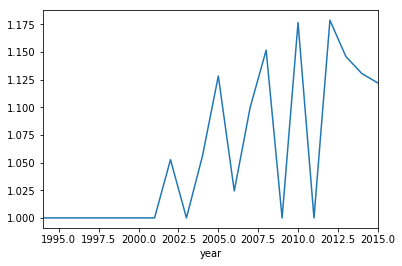

In [44]:
hfa_count[1994:2015].plot()

# 4. Incidence of Activisms

## 4.1 Number of Activisms

In [18]:
#calculate the number of activisms each year
activisms = HFA[pd.notnull(HFA['year'])]['year'].value_counts()
activisms = activisms.sort_index()
activists = HFA.drop_duplicates(['year','FundID'])
activists = activists['year'].value_counts()
activists = activists.sort_index()
num_com = com1['yeara'].value_counts()
num_com = num_com.sort_index()

In [19]:
tar_firm = HFA.drop_duplicates(['year','Permno'])
tar_firm = tar_firm['year'].value_counts()
incidence = tar_firm/num_com

## 4.2 Market Value of Targeted Firms

In [20]:
MV = pd.pivot_table(data2,values = 'mv',index = 'year',aggfunc = np.sum)

In [21]:
print(MV)

                  mv
year                
1994.0  6.016375e+03
1995.0  6.678964e+03
1996.0  2.366557e+04
1997.0  5.797490e+04
1998.0  3.500588e+04
1999.0  3.472305e+04
2000.0  4.777141e+04
2001.0  3.292327e+04
2002.0  6.221445e+04
2003.0  4.097734e+04
2004.0  2.151769e+05
2005.0  3.348872e+05
2006.0  4.476315e+05
2007.0  5.842890e+05
2008.0  3.788997e+05
2009.0  1.038680e+05
2010.0  2.234583e+05
2011.0  3.942954e+05
2012.0  3.689622e+05
2013.0  7.395372e+05
2014.0  1.011594e+06
2015.0  9.973818e+05
2016.0  1.303332e+04


## 4.3 Plot

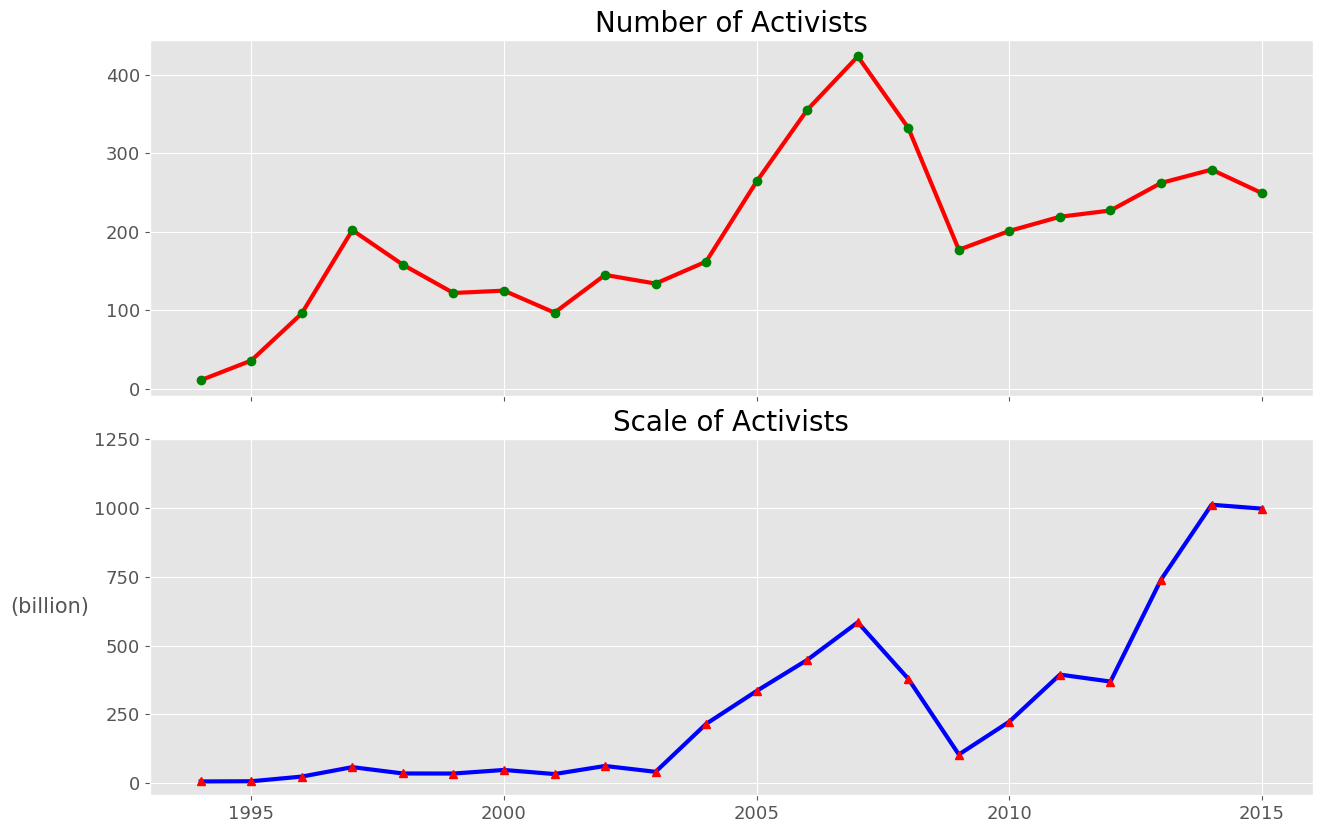

In [22]:
plt.style.use('ggplot')
fig1, ax = plt.subplots(2,1,sharex = True,figsize = (15,10),dpi = 100)

ax[0].plot(activisms.loc[1994:2015],linestyle = '-',lw = 3,color = 'red',\
           marker = 'o',markerfacecolor = 'green',markeredgecolor = 'green')
ax[0].set_xlim([1993,2016])
ax[0].set_xticks([1995,2000,2005,2010,2015])
ax[0].set_yticks(list(range(0,500,100)))
ax[0].set_yticklabels(list(range(0,500,100)),fontsize = 13)
ax[0].set_title('Number of Activists',fontsize = 20)

ax[1].plot(MV[1994:2015],linestyle = '-',lw = 3,color = 'blue',marker = '^',\
           markerfacecolor = 'red',markeredgecolor = 'red')
ax[1].set_title('Scale of Activists',fontsize = 20,loc = 'center')
ax[1].set_xticklabels([1995,2000,2005,2010,2015],fontsize = 13)
ax[1].set_yticks(list(range(0,1500000,250000)))
ax[1].set_yticklabels(list(range(0,1500,250)),fontsize = 13)
ax[1].set_ylabel('(billion)',rotation=0,horizontalalignment = 'right',\
                 verticalalignment = 'bottom',fontsize = 15)

plt.subplots_adjust(hspace = 0.12)

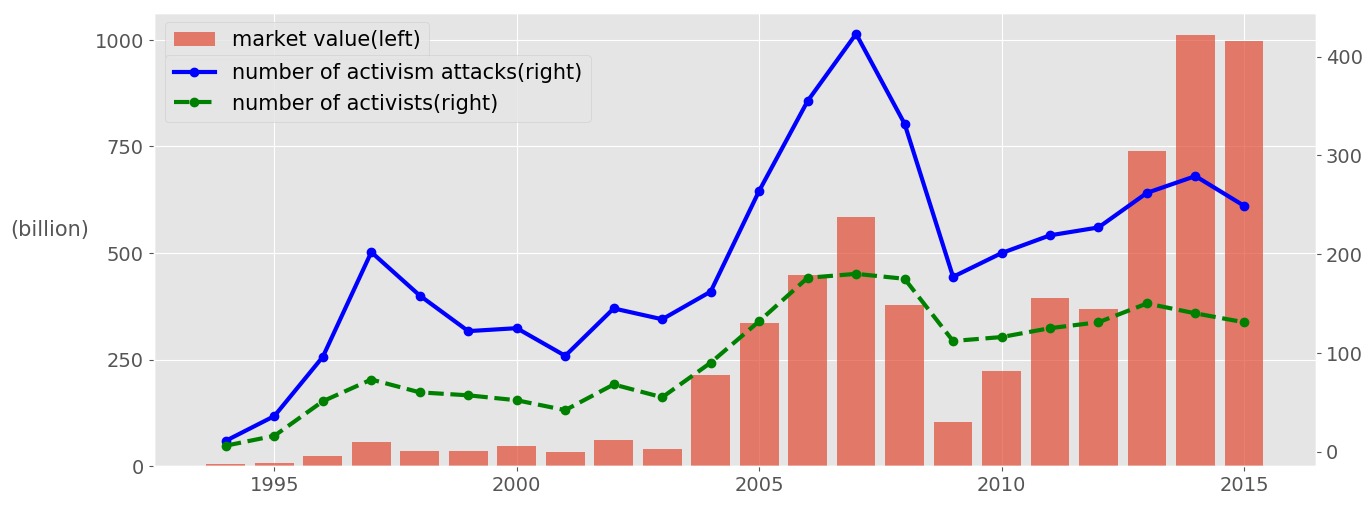

In [23]:
plt.style.use('ggplot')
fig2 = plt.figure(figsize = (15,6),dpi = 100)

ax1 = fig2.add_subplot(111)
# MV.columns = ["market value(left)"]
ax1.bar(np.arange(1994,2016),MV[1994:2015]['mv'],alpha = 0.7,label = "market value(left)")
ax1.set_xlim([1993,2016])
ax1.set_xticks([1995,2000,2005,2010,2015])
ax1.set_xticklabels([1995,2000,2005,2010,2015],fontsize = 14,rotation = 0)
ax1.set_yticks(list(range(0,1250000,250000)))
ax1.set_yticklabels(list(range(0,1250,250)),fontsize = 14)
ax1.set_ylabel('(billion)',rotation=0,horizontalalignment = 'right',\
               verticalalignment = 'bottom',fontsize = 15)
ax1.set_label("market value(left)")
ax1.legend(loc = (0.01,0.9),fontsize = 15)

ax2 = ax1.twinx()

ax2.plot(activisms[1994:2015],linestyle = '-',lw = 3,color = 'blue',\
        marker = 'o',\
         label = 'number of activism attacks(right)')
ax2.set_yticks([0,100,200,300,400])
ax2.set_yticklabels([0,100,200,300,400],fontsize = 14)

# ax2.set_title("Number and Scale of Activist 'attack'",fontsize = 30)
ax2.grid(False)

ax2.plot(activists[1994:2015],linestyle = '--'
         ,lw = 3,color = 'green',\
        marker = 'o',markerfacecolor = 'green',markeredgecolor = 'green',\
         label = 'number of activists(right)',markersize = 6)

ax2.legend(loc = (0.01,0.76),fontsize = 15)

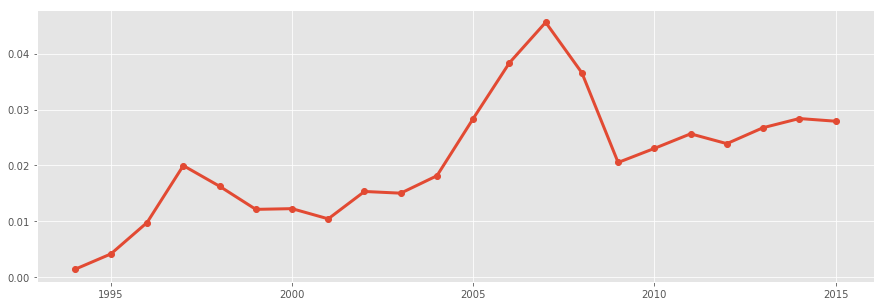

In [24]:
plt.style.use('ggplot')
fig3 = plt.figure(figsize = (15,5))
ax = fig3.add_subplot(111)
ax.plot(incidence[1994:2015],lw = 3,marker = 'o')
ax.set_xticks([1995,2000,2005,2010,2015])
# ax.set_title("The incidence of hedge fund activism",\
#              fontsize = 25)

# 5. Characteristics of Targeted Firms 

## 5.1 Market Value

In [25]:
# plt.style.use('ggplot')
# fig4 = plt.figure(figsize = (8,6),dpi = 100)
dist1 = data2['mvquant'].value_counts()
dist1 = dist1.sort_index()
dist1.index = ['Q1','Q2','Q3','Q4','Q5']
# dist1.plot(kind = 'bar',color = 'brown',\
#            title = "The distribution of targeted firms' market value")

In [26]:
dist1_ts = pd.pivot_table(data2,index = 'year',columns = 'mvquant',\
                          values = 'gvkey',\
                          aggfunc = np.count_nonzero)[1994:2015]
total = dist1_ts.sum(axis = 1)
dist1_ts_pct = dist1_ts.apply(lambda x: x/total)
dist1_ts_pct.columns = ['Q1','Q2','Q3','Q4','Q5']

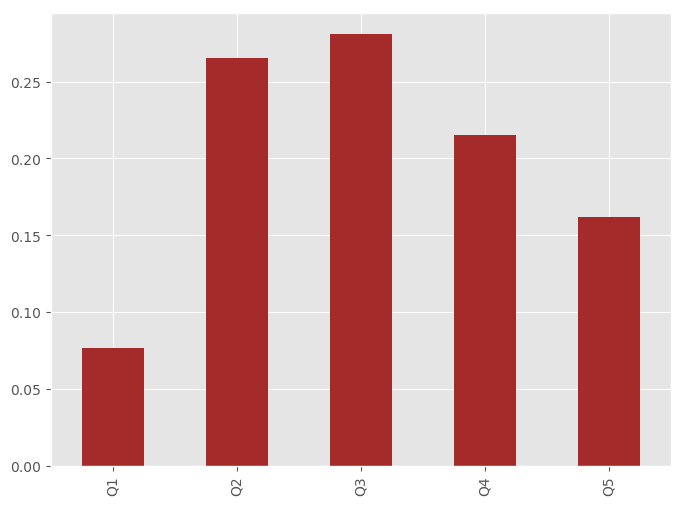

In [27]:
dist1_tpct = dist1_ts_pct.apply(np.mean,axis = 0)
fig10 = plt.figure(figsize = (8,6),dpi = 100)
dist1_tpct.plot(kind = 'bar',color = 'brown')
#            title = "The distribution of targeted firms' market value")

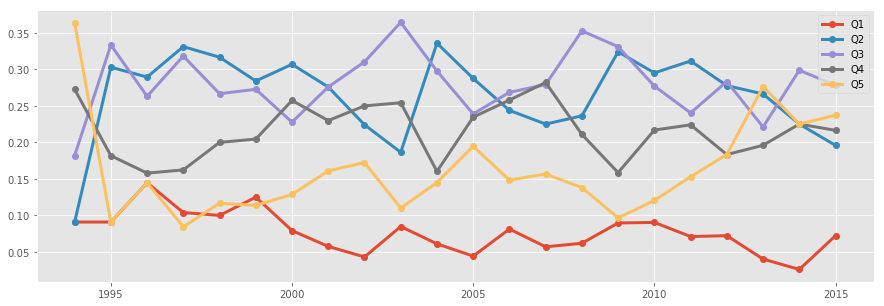

In [28]:
plt.style.use('ggplot')
fig5 = plt.figure(figsize = (15,5))
ax = fig5.add_subplot(111)
ax.plot(dist1_ts_pct,lw = 3,marker = 'o')
ax.set_xticks([1995,2000,2005,2010,2015])
ax.legend(dist1_ts_pct.columns,loc = 'best')
# ax.set_title("The change of percentage of tageted firms in different size",\
#              fontsize = 25)

In [29]:
df1 = pd.DataFrame({'total_mv_median':[0]*22,'tar_mv_median':[0]*22},\
                   index = list(range(1993,2015)))

for year in range(1993,2015):
    df1.loc[year,'total_mv_median'] = com1[com1['yeara'] == year].mv.median()
    df1.loc[year,'tar_mv_median'] = data2[data2['yeara'] == year].mv.median()

df1['diff'] = df1['tar_mv_median'] - df1['total_mv_median']

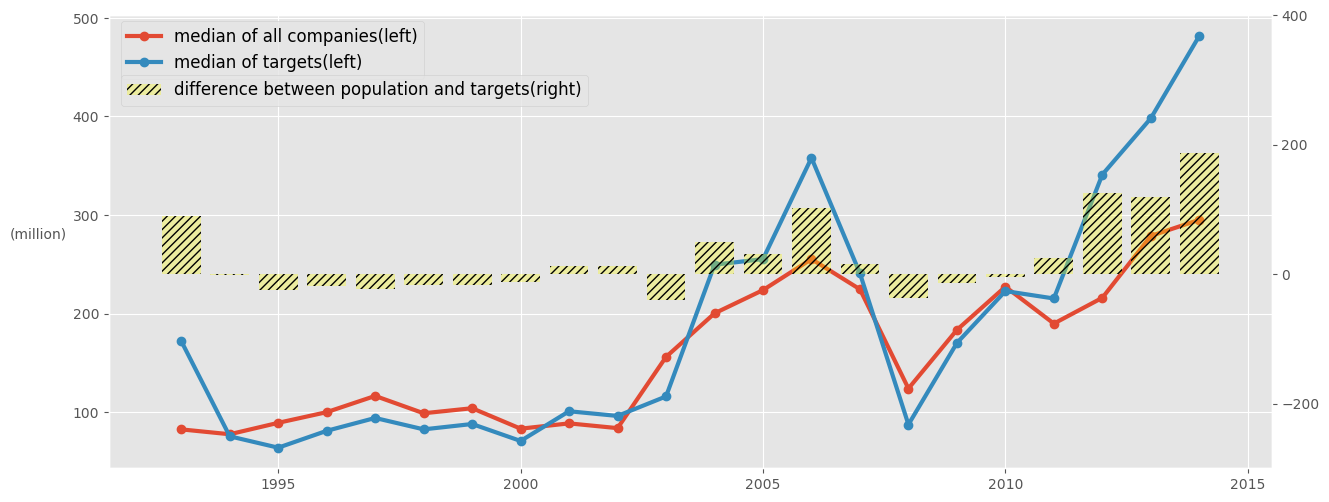

In [30]:
fig15 = plt.figure(figsize = (15,6),dpi = 100)
ax = fig15.add_subplot(111)
ax.plot(df1['total_mv_median'],lw = 3,marker = 'o',label = 'median of all companies(left)')
ax.plot(df1['tar_mv_median'],lw = 3,marker = 'o',label = 'median of targets(left)')
ax.legend(loc = (0.01,0.86),fontsize = 12)
ax.set_ylabel('(million)',rotation=0,horizontalalignment = 'right',\
               verticalalignment = 'bottom',fontsize = 10)

ax2 = ax.twinx()
ax2.bar(np.arange(1993,2015),df1['diff'],alpha = 0.3,hatch = '////',color = 'yellow',\
        label = 'difference between population and targets(right)')
ax2.legend(loc = (0.01,0.8),fontsize = 12)
ax2.grid(False)
ax2.set_ylim([-300,400])
ax2.set_yticks([-200,0,200,400])

## 5.2 Valuations 

In [31]:
# fig6 = plt.figure(figsize = (8,6),dpi = 100)
dist2 = data2['b2mquant'].value_counts()
dist2 = dist2.sort_index()
dist2.index = ['Q1','Q2','Q3','Q4','Q5']
# dist2.plot(kind = 'bar',color = 'gold',\
#            title = "The distribution of targeted firms' book-to-market ratio")

In [32]:
dist2_ts = pd.pivot_table(data2,index = 'year',columns = 'b2mquant',\
                          values = 'gvkey',\
                          aggfunc = np.count_nonzero)[1995:2015]
total = dist2_ts.sum(axis = 1)
dist2_ts_pct = dist2_ts.apply(lambda x: x/total)
dist2_ts_pct.columns = ['Q1','Q2','Q3','Q4','Q5']

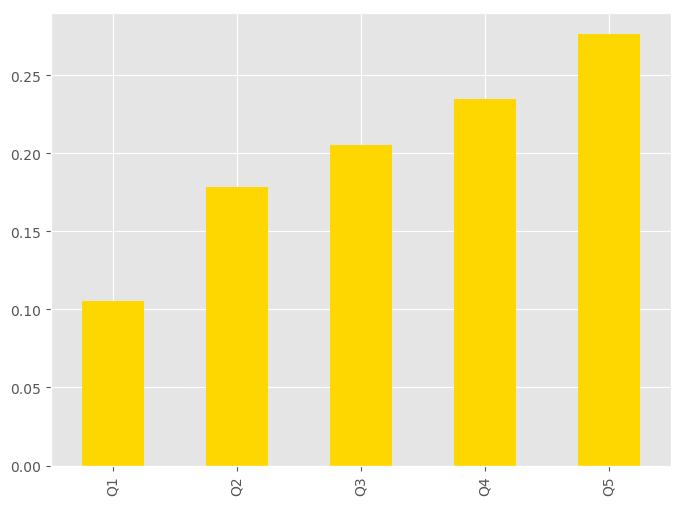

In [33]:
dist2_tpct = dist2_ts_pct.apply(np.mean,axis = 0)
fig11 = plt.figure(figsize = (8,6),dpi = 100)
dist2_tpct.plot(kind = 'bar',color = 'gold')
#            title = "The distribution of targeted firms' market value")

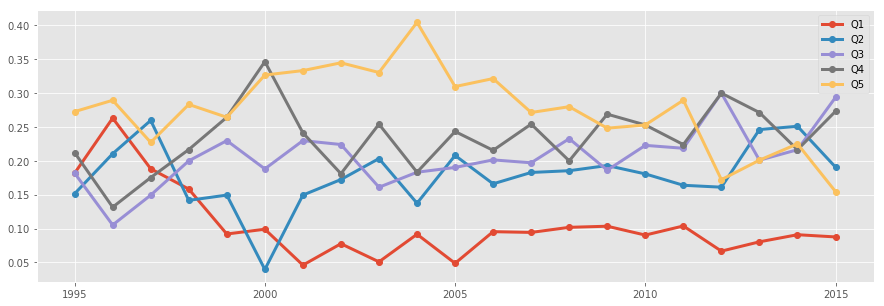

In [34]:
fig7 = plt.figure(figsize = (15,5))
ax = fig7.add_subplot(111)
ax.plot(dist2_ts_pct,lw = 3,marker = 'o')
ax.set_xticks([1995,2000,2005,2010,2015])
ax.legend(dist2_ts_pct.columns,loc = 'best')
# ax.set_title("The percentage of tageted \
# firms with different book-to-market ratio",fontsize = 25)

In [35]:
df2 = pd.DataFrame({'total_b2m_median':[0]*22,'tar_b2m_median':[0]*22},\
                   index = list(range(1993,2015)))

for year in range(1993,2015):
    df2.loc[year,'total_b2m_median'] = com1[com1['yeara'] == year].b2m.median()
    df2.loc[year,'tar_b2m_median'] = data2[data2['yeara'] == year].b2m.median()

df2['diff'] = df2['tar_b2m_median'] - df2['total_b2m_median']

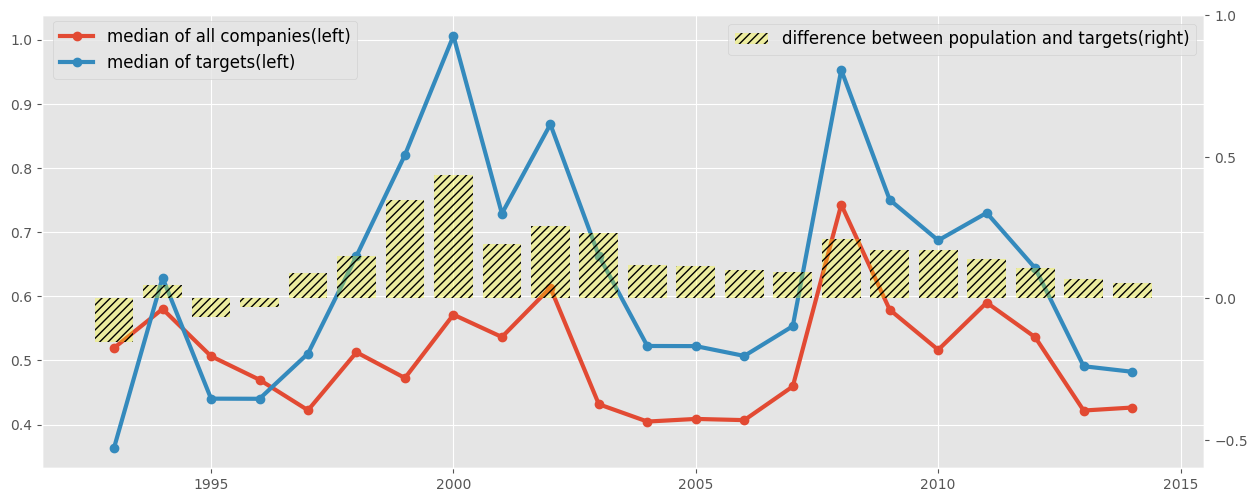

In [36]:
fig16 = plt.figure(figsize = (15,6),dpi = 100)
ax = fig16.add_subplot(111)
ax.plot(df2['total_b2m_median'],lw = 3,marker = 'o',label = "median of all companies(left)")
ax.plot(df2['tar_b2m_median'],lw = 3,marker = 'o',label = 'median of targets(left)')
ax.legend(loc = (0.01,0.86),fontsize = 12)

ax2 = ax.twinx()
ax2.bar(np.arange(1993,2015),df2['diff'],alpha = 0.3,hatch = '////',color = 'yellow',\
       label = 'difference between population and targets(right)')
ax2.legend(loc = 'best',fontsize = 12)
ax2.grid(False)
ax2.set_ylim([-0.6,1])
ax2.set_yticks([-0.5,0,0.5,1])

In [37]:
# fig8 = plt.figure(figsize = (8,6),dpi = 100)
sub = data2[data2['qquant'].isin([1,2,3,4,5])]
dist3 = sub['qquant'].value_counts()
dist3 = dist3.sort_index()
dist3.index = ['Q1','Q2','Q3','Q4','Q5']
# dist3.plot(kind = 'bar',color = 'green',\
#            title = "The distribution of targeted firms' q")

In [38]:
dist3_ts = pd.pivot_table(sub,index = 'year',columns = 'qquant',\
                          values = 'gvkey',\
                          aggfunc = np.count_nonzero)[1995:2015]
total = dist3_ts.sum(axis = 1)
dist3_ts_pct = dist3_ts.apply(lambda x: x/total)
dist3_ts_pct.columns = ['Q1','Q2','Q3','Q4','Q5']

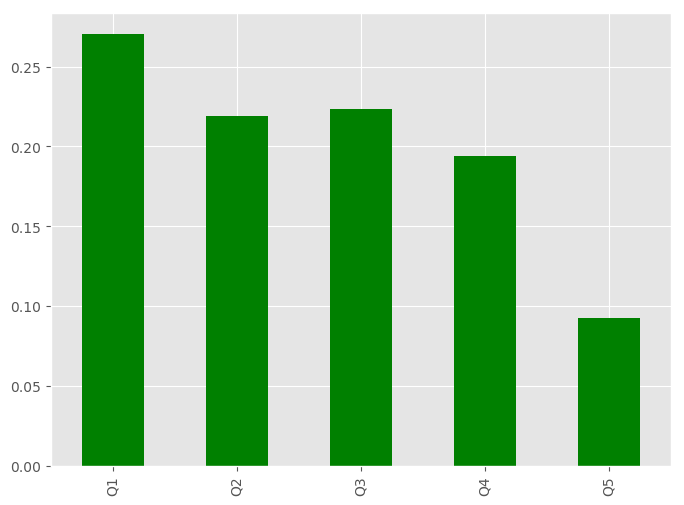

In [39]:
dist3_tpct = dist3_ts_pct.apply(np.mean,axis = 0)
fig12 = plt.figure(figsize = (8,6),dpi = 100)
dist3_tpct.plot(kind = 'bar',color = 'green')
#            title = "The distribution of targeted firms' q")

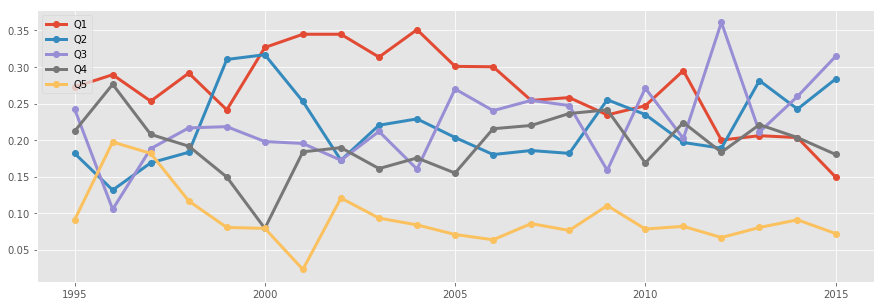

In [40]:
fig9 = plt.figure(figsize = (15,5))
ax = fig9.add_subplot(111)
ax.plot(dist3_ts_pct,lw = 3,marker = 'o')
ax.set_xticks([1995,2000,2005,2010,2015])
ax.legend(dist3_ts_pct.columns,loc = 'best')
# ax.set_title("The percentage of tageted \
# firms with different q",fontsize = 25)

In [41]:
df3 = pd.DataFrame({'total_q_median':[0]*22,'tar_q_median':[0]*22},\
                   index = list(range(1993,2015)))

for year in range(1993,2015):
    df3.loc[year,'total_q_median'] = com1[com1['yeara'] == year].q.median()
    df3.loc[year,'tar_q_median'] = data2[data2['yeara'] == year].q.median()

df3['diff'] = df3['tar_q_median'] - df3['total_q_median']

(-1.2, 1.2)

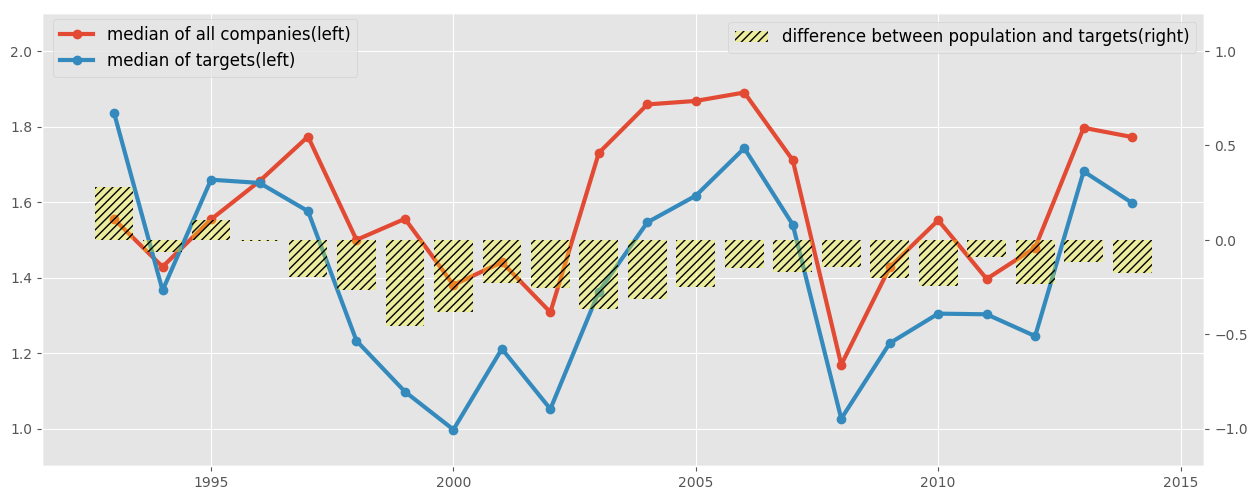

In [42]:
fig17 = plt.figure(figsize = (15,6),dpi = 100)
ax = fig17.add_subplot(111)
ax.plot(df3['total_q_median'],lw = 3,marker = 'o',label = 'median of all companies(left)')
ax.plot(df3['tar_q_median'],lw = 3,marker = 'o',label = 'median of targets(left)')
ax.legend(loc = (0.01,0.86),fontsize = 12)
ax.set_ylim([0.9,2.1])

ax2 = ax.twinx()
ax2.bar(np.arange(1993,2015),df3['diff'],alpha = 0.3,hatch = '////',color = 'yellow',\
       label = 'difference between population and targets(right)')
ax2.legend(loc = 'best',fontsize = 12)
ax2.grid(False)
ax2.set_ylim([-1.2,1.2])